# Computing phases for an equilateral triangle of Verticals

## Introduction
I recently watched a [DX Commander video](https://www.youtube.com/watch?v=qLsf5ZbNEMw) 

## A quick note on angles before getting started
There are two common units in which to express angles: degrees, which we all know and love, and radians.  Radians are used throughout physics and engineering to specify angles, so we give a quick refresher here.  Let the greek letter phi ($\phi$) represent an angle.  There are $2 \pi$ radians in 360 degrees.  This means the translation between the two is
$$\phi_{deg} = \phi_{rad}\frac{180}{\pi}$$
and
$$\phi_{rad} = \phi_{deg}\frac{\pi}{180}$$

So, here's a quick example.  Let's say I want to translate 45 degrees into radians

$$
\phi_{rad} = 45\frac{\pi}{180} = \frac{\pi}{4}\text{radians}
$$


## The physics of phase matching
If I have two radiators that emit waves, those waves will "interfere" with each other.  We say these waves are "in phase" when the peaks and troughs coincide.  We say they are "180 degrees" out of phase when their peaks an troughs cancel each other out.

If I want two radiors to maximize their power into a given direction, I need to make sure that those waves are "in phase" at a receiver located in that direction.  Let's draw a picture of these two radiators (call then "a" and "b") and a reciever located far away from then at some angle. In the diagram, we have located the first radiator (a) at the origin of a coordinates system.  The "b" radiator is a short distance $|r_b|$ away oriented at an angle of $\theta_b$ from the x axis.  The reciever is at some really large distance $|r_p|$ away from the the radiators and oriented at an angle of $\theta_p$ with respect to the x axis.

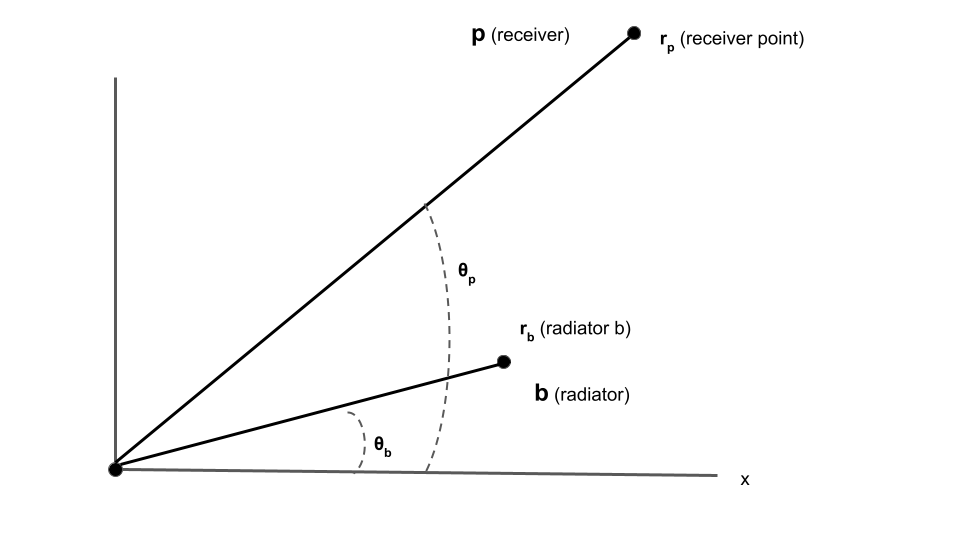

In [230]:
from IPython.display import Image
Image(filename='./two_radiator_phase.png')

Now if we want the signals from both radiators to arrive at the reciever point, p, in phase, we are going to have to compensate for the head start that radiator b has, since it it closer.  That means we are going to have to subtract off some effective distance by lagging the phase.  This phase lag will exactly match and cancel out the head start of the b radiator.

So, what is this head start?  It's just the projection of $\mathbf{r_b}$ in the direction of the receiver $\mathbf{\hat{r}_p)}$.  This projection is
$$\mathbf{r_b \cdot \hat{r}_p} = |\mathbf{r_b}|\cos(\theta_p - \theta_b)$$

We can translate this headstart into a required phase lag by considering the fraction of a wavelenth it represents and multiplying by the $2\pi$ radians corresponsing to a full wavelength (we denote the wavelengh by the greek letter lambda $\lambda$, or
$$
\phi_b = -\frac{2\pi|r_b|}{\lambda}\cos(\theta_p - \theta_b)
$$

## The geometry of an equalateral triangle array
We can now use the phase expression above to compute the phase lags needed to direct the radiation from a triangular phased array into any direction we want.  First, let's draw a diagram of our array.

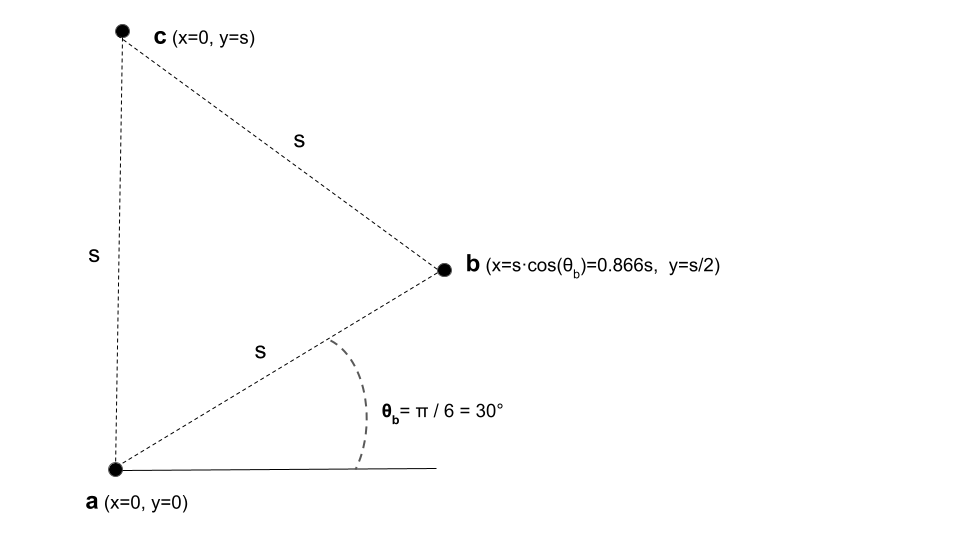

In [233]:
Image(filename='./triangle_array.png')

Here we have three radiators at the vertices of an equilateral triangle.  We place radiator a at the origin.  The sides of the triangle are all the same distance s.  Now, given this geometry, we should be able to direct radiation wherever we want to by properly selecting the phases of the radiators.

Let's say we want to maximize radiation at an angle of $\theta$ with respect to the x axis.  We will set the phase of the **a** radiator to zero and what the phases for the other radiators must be.  We do that using the formulat developed above.

For the **b** radiator we obtain the phase
$$
\phi_b =- \frac{2\pi s}{\lambda}\cos\left(\theta - \frac{\pi}{6}\right)
$$
And for the **c** radiator, we get
$$
\phi_c =- \frac{2\pi s}{\lambda}\cos\left(\theta - \frac{\pi}{2}\right)
$$


Now let's specialize this to the case where we have a quarter wavelength inter-element separation, $s = \frac{\lambda}{4}$.  Let's also say that we want to send radiation directed along the x axis, so $\theta=0$. Plugging in the numbers, we obtain
$$
\phi_b =- \frac{\pi}{2}\cos\left(- \frac{\pi}{6}\right) = 1.36 \text{ radians} = 77.9^{\circ}
$$
And for the **c** radiator, we get
$$
\phi_c =- \frac{\pi}{2}\cos\left(- \frac{\pi}{2}\right) = 0
$$


## Sanity check with simple simulation
We can now write a little code to make sure that the formulas above seem reasonable.  If you are not into writing python code, you can just skip down to the charts below to see that the formula do indeed seem to to work.

In [ ]:
import numpy as np
import easier as ezr
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config Completer.use_jedi = False

In [238]:
class Element:
    c = 3e8
    def __init__(self, freq, r0_vector_in_wavelengths, phase=0, name=''):
        self.phi0 = phase 
        self.f = freq
        self.lamda = self.c / self.f
        self.k = 2 * np.pi / self.lamda
        self.r0 = self.lamda * np.array(r0_vector_in_wavelengths)
        self.name = name
        
    def phase_to(self, r_vector):
        R_vector = np.array(r_vector) - self.r0
        R_mag = np.sqrt(np.sum(R_vector ** 2, axis=-1))
        phase = self.k * R_mag
        return np.exp(1j * (phase - self.phi0))
    
    @ezr.cached_property
    def r(self):
        return np.sqrt(np.sum(self.r0 ** 2)) / self.lamda
    
    def set_phase(self, phase):
        self.phi0 = phase
    
    
class Array:
    def __init__(self, freq, coords, names=None):
        """
        args = list of lists.  [[x1, y1, phase_radians1], ... [xN, yN, phase_radiansN]]
        """
        if names is None:
            names = ['' for c in coords]
        self.elements = [Element(freq, coord, name=name) for (coord, name) in zip(coords, names)]
        
    def plot_elements(self):
        x = []
        y = []
        names = []
        for el in self.elements:
            x.append(el.r0[0] / el.lamda)
            y.append(el.r0[1] / el.lamda)
            names.append(el.name)
            
        ax = ezr.figure(figsize=(3, 3), grid=False)
        ax.scatter(x, y)
        
        for (xi, yi, name) in zip(x, y, names):
            if name:
                ax.text(xi, yi, name, ha='left', va='bottom', size='large')
        ax.axis('square')
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    def plot_pattern(self, show=True):
        r = 1000 * max([e.r for e in self.elements])
        phi = np.linspace(0, 2 * np.pi, 3000)
        x_vals = r * np.cos(phi)
        y_vals = r * np.sin(phi)
        XY = np.vstack((x_vals, y_vals)).T
        
        Z = np.zeros_like(phi)
        for element in self.elements:
            Z = Z + element.phase_to(XY)
            
        P = (np.conj(Z) * Z).real
        P = P / np.mean(P)
        
        P = 10 * np.log10(P + 1e-6)
        P = np.maximum(P, -20)

        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.plot(phi, P)
        ax.grid(True)
        
        min_val = np.max([-10, np.floor(np.min(P)) - 1])
        max_val = np.ceil(np.max(P)) + 1
        ax.set_ylim(min_val, max_val)
        ax.set_title(f'gmax={np.round(np.max(P), 2)}', va='bottom')
        if show:
            plt.show()
        return ax
        
        
        
class DeltaArray(Array):
    def __init__(self, freq, side_in_wavelengths=.25):
        k = 2 * np.pi
        s = side_in_wavelengths
        self.s, self.k = s, k
        
        theta_b = np.pi / 6
        
        coords = [
            [0, 0],
            [s * np.cos(theta_b), .5 * s],
            [0, s] 
        ]
        
        names = [
            'a',
            'b',
            'c',
        ]
        
        super().__init__(freq, coords, names)
        
    def plot_pattern(self, theta_degrees):
        theta = np.pi * theta_degrees / 180
        s = self.s
        k = self.k
        phase_lookup = {
            'a': 0,
            'b': -k * s * np.cos(theta - np.pi / 6),
            'c': -k * s * np.cos(theta - np.pi / 2)                     
        }
        self.phase_lookup = phase_lookup
        for element in self.elements:
            element.set_phase(phase_lookup[element.name])
        ax = super().plot_pattern(show=False)
        phase_a = np.round(phase_lookup['a'] * 180 / np.pi, 0)
        phase_b = np.round(phase_lookup['b'] * 180 / np.pi, 0)
        
        title = f'dir={theta_degrees} {ax.get_title()}  a={phase_a} b={phase_b}'
        ax.set_title(title)
        
        
# array = DeltaArray(freq=7.15e6,  side_in_wavelengths=1/3)
# array.plot_pattern(0)

## A 40 meter Triangular araray
Let's use this code to create a 40-meter triangular array with side lengths of a quarter wavelength.

In [240]:
array = DeltaArray(freq=7.15e6, side_in_wavelengths=.25)

Now let's plot the radiators to make sure they actually look like an equilateral triangle

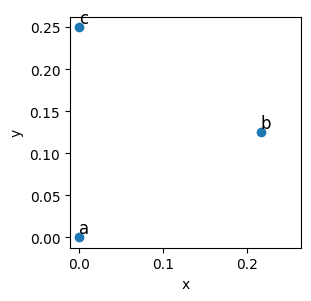

In [241]:
array.plot_elements()

That looks reasonable.  Now lets' plot the pattern for sending radiation along the x-axis

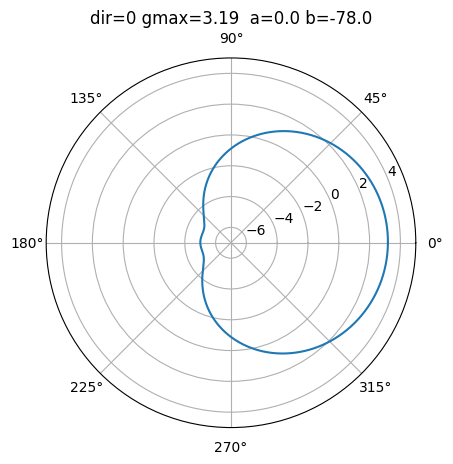

In [242]:
array.plot_pattern(theta_degrees=0)

So, a triangle of 3-d isotropic radiators (such a thing doesn't actually exist) would have a maximum of 3.19 db gain along the x axis.  Cool! Note that the figure title is sayin "dir=0" which means we intended to shoot radiation at $\theta=0$.  The max gain was 3.19 db.   The phase of the a radiator was zero, and the phase of the b radiator was -78 degrees.

Now let's try it for several other directions.

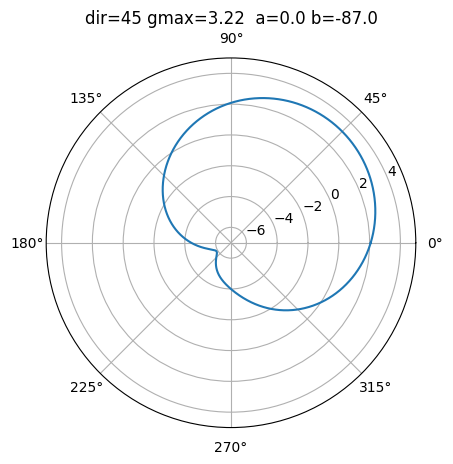

In [247]:
array.plot_pattern(theta_degrees=45)

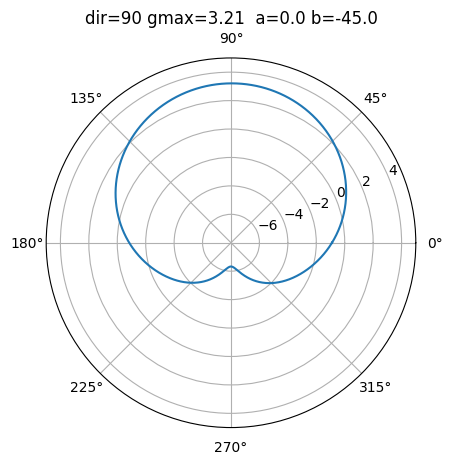

In [248]:
array.plot_pattern(theta_degrees=90)

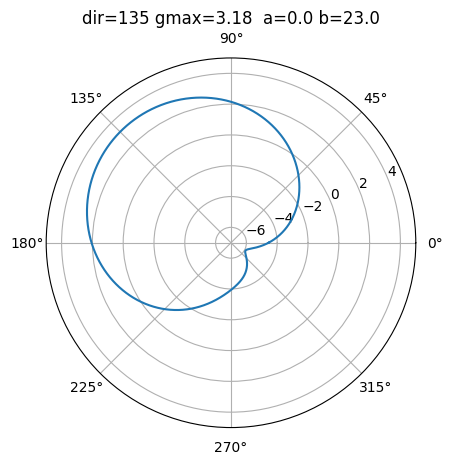

In [249]:
array.plot_pattern(theta_degrees=135)

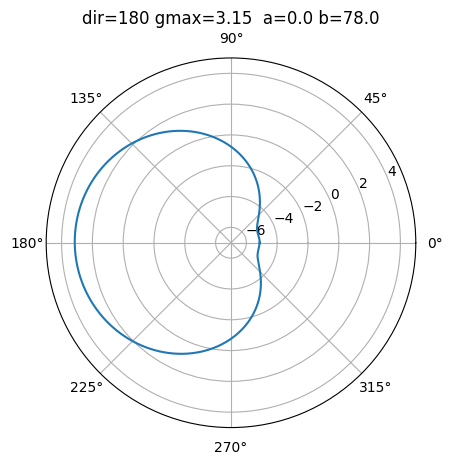

In [250]:
array.plot_pattern(theta_degrees=180)